In [8]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from utils import logp as logp_scale
from Zappa.zappa import zappa_sampling_multivariate, zappa_sampling
from Zappa.ZappaStore import Zappa
from Manifolds.RotatedEllipse import RotatedEllipse
from utils import quick_MVN_scatter, MVN_scatters, prep_contour
from numpy.random import rand
from numpy.linalg import norm, solve, inv, det
from scipy.optimize import fsolve, root
from Manifolds.Manifold import Manifold
from tangential_hug_functions import HugAcceleration

In [9]:
# Various settings
z = 0.02                 # Density value on contour (0.01)
n = 1000                  # Number of Zappa samples
tol = 1.48e-08           # Tolerance for projection optimization
a_guess = np.array([0])  # Initial guess of a for projection
T = 0.5                  # Total integration time for one iteration of Hug
B = 5                    # Number of sub-iterations per hug iteration
alpha = 0.95              # Percentage of gradient to remove
eps = 0.01                # Error allowed on the manifold
hug_scale = 0.5          # Scale for proposal in hug  0.05
thug_scale = 1.0         # Scale for proposal in tangential hug  1.0

In [10]:
# Perfect manifold is just z-contour of a MVN
mu = np.zeros(2)
Sigma = np.array([[1.0, 0.99], [0.99, 2.0]])
target = multivariate_normal(mu, Sigma)
manifold = RotatedEllipse(mu, Sigma, z)
x0 = manifold.to_cartesian(np.random.uniform(0, 2*np.pi))

In [16]:
q_hug = multivariate_normal(mean=np.zeros(2), cov=hug_scale*np.eye(2))
q_sample_h = q_hug.rvs
logq_h = q_hug.logpdf
# Target is just the MVN whose contour we are sampling
logpi = target.logpdf
grad_log_pi = lambda xy: - solve(Sigma, xy)

# Notes

The acceleration can be computed exactly in this case since $H(x) = -\Sigma^{-1}$.
$$
a(x, v) =  - \frac{v^\top \Sigma^{-1} v}{||g(x)||} \hat{g}(x)
$$

The position-verlet algorithm would then become
$$
\begin{align}
    x_{t+\delta/2} &= x_t + \frac{\delta}{2} v_t \\
    v_{t+\delta} &= v_t + \delta a(v_t, x_{t+\delta/2}) = v_t - \delta \frac{v_t^\top \Sigma^{-1} v_t}{||g_{t+\delta/2}||} \hat{g}_{t+\delta/2}\\
    x_{t+\delta} &= x_{t+\delta/2} + \frac{\delta}{2} v_{t+\delta}
\end{align}
$$

As another check, one can compute an alternative $\mathcal{O}(\delta^2)$ approximation to the quadratic form via the Taylor series
$$
\ell_{t+\delta/2} = \ell_t + \frac{\delta^2}{8} v_t^\top H(\mathring{x}) v_t + \mathcal{O}(\delta^2)\qquad\qquad \mathring{x}\in(x_t, x_{t+\delta/2})
$$

rearranging we get

$$
-8 \frac{\ell_{t+\delta/2} - \ell_t}{\delta||g_t||} \hat{g}_t \approx -\delta \frac{v_t^\top H(\mathring{x})v_T}{||g_t||} \hat{g}_t = \delta a(v_t, x_t)
$$

Giving the following discretization

$$
\begin{align}
    x_{t+\delta/2} &= x_t + \frac{\delta}{2} v_t \\
    v_{t+\delta} &= v_t + \delta a(v_t, x_{t+\delta/2}) \approx v_t -8 \frac{\ell_{t+\delta/2} - \ell_t}{\delta||g_{t+\delta/2}||} \hat{g}_{t+\delta/2}\\
    x_{t+\delta} &= x_{t+\delta/2} + \frac{\delta}{2} v_{t+\delta}
\end{align}
$$

# Exact Algorithm

In [15]:
def HugExact(x0, T, B, n, q_sample, logq, logpi, grad_log_pi, Sigma):
    """Exact Hug. No tangential."""
    samples, acceptances = x0, np.zeros(n)
    for i in range(n):
        v0 = q_sample()       # Draw velocity
        v, x = v0, x0         # Housekeeping
        logu = np.log(rand()) # Uniform variate for acceptance ratio
        delta = T / B         # Compute step size

        for _ in range(B):
            x = x + delta*v/2                                        # Move to halfpoint
            g = grad_log_pi(x)                                       # Compute gradient at halfpoint
            v = v - delta * (v @ solve(Sigma, v)) * g / (norm(g)**2) # Exact velocity update
            x = x + delta*v/2                                        # Full position step 

        if logu <= logpi(x) + logq(v) - logpi(x0) - logq(v0):
            samples = np.vstack((samples, x))
            acceptances[i] = 1         # Accepted!
            x0 = x
        else:
            samples = np.vstack((samples, x0))
            acceptances[i] = 0         # Rejected
    return samples, acceptances

In [ ]:
def HugExactTan(x0, T, B, n, alpha, q_sample, logq, logpi, grad_log_pi, Sigma):
    """Exact Hug. No tangential."""
    samples, acceptances = x0, np.zeros(n)
    for i in range(n):
        v0s = q_sample()      # Draw spherical velocity
        g = grad_log_pi(x0)
        g = g / norm(g)
        v0 = v0s - alpha * g * (g @ v0s)
        v, x = v0, x0         # Housekeeping
        logu = np.log(rand()) # Uniform variate for acceptance ratio
        delta = T / B         # Compute step size

        for _ in range(B):
            x = x + delta*v/2                                        # Move to halfpoint
            g = grad_log_pi(x)                                       # Compute gradient at halfpoint
            v = v - delta * (v @ solve(Sigma, v)) * g / (norm(g)**2) # Exact velocity update
            x = x + delta*v/2                                        # Full position step
        # Unsqueeze the velocity
        g = grad_log_pi(x)
        g = g / norm(g)
        v = v + (alpha / (1 - alpha)) * g * (g @ v)

        if logu <= logpi(x) + logq(v) - logpi(x0) - logq(v0):
            samples = np.vstack((samples, x))
            acceptances[i] = 1         # Accepted!
            x0 = x
        else:
            samples = np.vstack((samples, x0))
            acceptances[i] = 0         # Rejected
    return samples, acceptances

In [17]:
exact_samples, _ = HugExact(x0, T, B, n, q_sample_h, logq_h, logpi, grad_log_pi, Sigma)

# Log Density Approximation

In [24]:
def HugLogDensity(x0, T, B, n, q_sample, logq, logpi, grad_log_pi):
    """Exact Hug. No tangential."""
    samples, acceptances = x0, np.zeros(n)
    for i in range(n):
        v0 = q_sample()       # Draw velocity
        v, x = v0, x0         # Housekeeping
        logu = np.log(rand()) # Uniform variate for acceptance ratio
        delta = T / B         # Compute step size

        for _ in range(B):
            logpi1 = logpi(x)
            x = x + delta*v/2                                         # Move to halfpoint
            g = grad_log_pi(x)                                        # Compute gradient at halfpoint
            g_hat = g / norm(g)                                       # Normalize gradient
            v = v - 8 * (logpi(x) - logpi1) * g_hat / (delta*norm(g)) # Log density approx velocity update
            x = x + delta*v/2                                         # Full position step 

        if logu <= logpi(x) + logq(v) - logpi(x0) - logq(v0):
            samples = np.vstack((samples, x))
            acceptances[i] = 1         # Accepted!
            x0 = x
        else:
            samples = np.vstack((samples, x0))
            acceptances[i] = 0         # Rejected
    return samples, acceptances

In [27]:
logdensity_samples, _ = HugLogDensity(x0, T, B, n, q_sample_h, logq_h, logpi, grad_log_pi)

# Corrected Hug

In [29]:
def HugCorrected(x0, T, B, n, q_sample, logq, logpi, grad_log_pi):
    """Standard Hug"""
    samples, acceptances = x0, np.zeros(n)
    for i in range(n):
        v0 = q_sample()       # Draw velocity
        v, x = v0, x0         # Housekeeping
        logu = np.log(rand()) # Uniform variate for acceptance ratio
        delta = T / B         # Compute step size

        for _ in range(B):
            x = x + delta*v/2               # Move
            g1 = grad_log_pi(x)             # gradient at midpoint
            g1hat = g1 / norm(g1)           # normalize gradient at midpoint
            g2 = grad_log_pi(x + delta/2*v) # Gradient at full point
            g2hat = g2 / norm(g2)           # normalize gradient at full point
            v = v - 2*(v @ g2hat) * g1hat   # Reflect
            x = x + delta*v/2               # Move

        if logu <= logpi(x) + logq(v) - logpi(x0) - logq(v0):
            samples = np.vstack((samples, x))
            acceptances[i] = 1         # Accepted!
            x0 = x
        else:
            samples = np.vstack((samples, x0))
            acceptances[i] = 0         # Rejected
    return samples, acceptances


In [30]:
corrected_samples, _ = HugCorrected(x0, T, B, n, q_sample_h, logq_h, logpi, grad_log_pi)

# Hug

In [34]:
def Hug(x0, T, B, n, q_sample, logq, logpi, grad_log_pi):
    """Standard Hug"""
    samples, acceptances = x0, np.zeros(n)
    for i in range(n):
        v0 = q_sample()       # Draw velocity
        v, x = v0, x0         # Housekeeping
        logu = np.log(rand()) # Uniform variate for acceptance ratio
        delta = T / B         # Compute step size

        for _ in range(B):
            x = x + delta*v/2               # Move
            g = grad_log_pi(x)              # gradient at midpoint
            ghat = g / norm(g)              # normalize gradient at midpoint
            v = v - 2*(v @ ghat) * ghat     # Reflect
            x = x + delta*v/2               # Move

        if logu <= logpi(x) + logq(v) - logpi(x0) - logq(v0):
            samples = np.vstack((samples, x))
            acceptances[i] = 1         # Accepted!
            x0 = x
        else:
            samples = np.vstack((samples, x0))
            acceptances[i] = 0         # Rejected
    return samples, acceptances

In [35]:
hsamples, _ = Hug(x0, T, B, n, q_sample_h, logq_h, logpi, grad_log_pi)

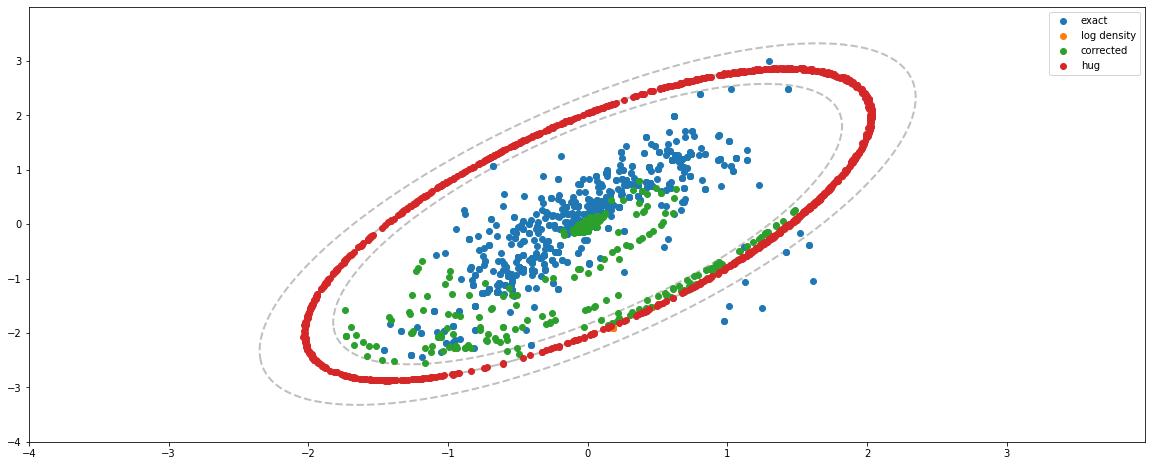

In [36]:
xlims=[-4,4]
ylims=[-4,4]
step = 0.01
# Grid of points for contour plot
x, y = np.mgrid[xlims[0]:xlims[1]:step, ylims[0]:ylims[1]:step]
pos = np.dstack((x, y))

fig, ax = plt.subplots(figsize=(20, 8))
ax.contour(x, y, target.pdf(pos), linewidths=2, levels=[z], alpha=0.5, zorder=1, colors='gray')
ax.contour(x, y, target.pdf(pos), linewidths=2, linestyles='dashed', levels=[z+eps], alpha=0.5, zorder=1, colors='gray')
ax.contour(x, y, target.pdf(pos), linewidths=2, linestyles='dashed', levels=[z-eps], alpha=0.5, zorder=1, colors='gray')
ax.scatter(*exact_samples.T, label='exact')
ax.scatter(*logdensity_samples.T, label='log density')
ax.scatter(*corrected_samples.T, label='corrected')
ax.scatter(*hsamples.T, label='hug')
ax.legend()
plt.show()